In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import tensorflow as tf

In [2]:
%%time
import edward as ed
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture,Empirical

Wall time: 10.7 s


In [3]:
# priori model test

sess = ed.get_session()
tf.global_variables_initializer().run()

In [4]:
import pickle
with open('cache_dict_float32','rb') as f:
    cache_dict_float32 = pickle.load(f)
    
stage_list = cache_dict_float32['stage_list_float32']
time_length_list = cache_dict_float32['time_length_list']
latent_scen_4_meansd = cache_dict_float32['latent_scen_4_meansd']

stage_list[0].dtype

dtype('float32')

In [5]:
stage = stage_list[0] 
stage.shape # stage 1 obs


(202, 4, 193)

In [6]:
meansd = np.array(latent_scen_4_meansd[0],dtype='float32') # stage 1 
time_length = np.array(time_length_list[0],dtype='float32') # stage 1

meansd.shape,time_length.shape

((5, 5, 2), (4, 2))

In [7]:
period_num = meansd.shape[0] # in stage 1 -> 5
var_num = meansd.shape[1] # always 5
durations_num = time_length.shape[0] # in stage 1 -> 4
assert time_length.shape[0] == period_num - 1
replay_num = stage.shape[0] # obs

period_num,var_num,durations_num,replay_num

(5, 5, 4, 202)

In [8]:
emu = np.array([stage[:,0,:80].mean(),stage[:,0,80:131].mean(),stage[:,0,131:].mean()],dtype='float32')
esd = np.array([stage[:,0,:80].std(),stage[:,0,80:131].std(),stage[:,0,131:].std()],dtype='float32')

emu

array([ 21.84028435,  40.84634018,   5.01133823], dtype=float32)

In [9]:
stage_length = stage.shape[2]
time_axis = np.arange(stage_length, dtype='float32')
_time_axis = np.tile(time_axis,(replay_num, durations_num, 1)) # add batch...
_time_axis.shape

(202, 4, 193)

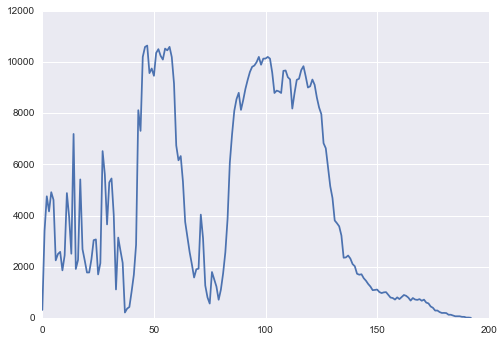

In [10]:
plt.plot(stage_list[0][:,0,:].sum(0))

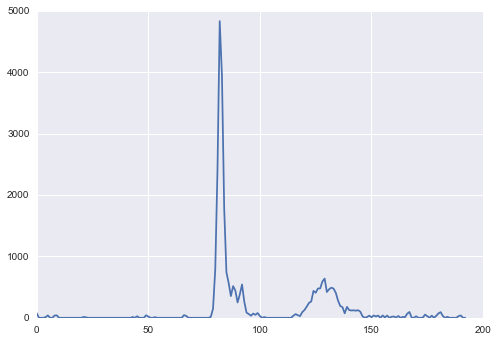

In [11]:
plt.plot(stage_list[0][:,1,:].sum(0))

这里我们开始恢复使用五阶段（四持续时间）方法来重新建立基线模型以及前面那些坑逼模型。

首先先重新一般化回五阶段模型，用stage的参数替换掉以前硬编码的那些参数。实验一下五阶段模型再退化会只针对ctrl建模的模型，
然后再把duration决定参数一般化为多策略模型。

In [12]:
meansd

array([[[  2.18402843e+01,   1.00000000e+01],
        [  3.54579203e-02,   1.00000000e+01],
        [  4.56683151e-02,   1.00000000e+01],
        [  1.89574936e+02,   1.00000000e+01],
        [  1.26586617e+02,   1.00000000e+01]],

       [[  1.14839106e+01,   1.00000000e+01],
        [  1.48279705e+01,   1.00000000e+01],
        [  7.30198026e-02,   1.00000000e+01],
        [  1.74373138e+02,   1.00000000e+01],
        [  1.38980789e+02,   1.00000000e+01]],

       [[  4.33452721e+01,   1.00000000e+01],
        [  1.13629663e+00,   1.00000000e+01],
        [  1.68316826e-01,   1.00000000e+01],
        [  8.65855789e+01,   1.00000000e+01],
        [  9.01471710e+01,   1.00000000e+01]],

       [[  1.76967831e+01,   1.00000000e+01],
        [  2.27722764e+00,   1.00000000e+01],
        [  5.69306947e-02,   1.00000000e+01],
        [  5.34375000e+01,   1.00000000e+01],
        [  9.23385925e+01,   1.00000000e+01]],

       [[  4.13647985e+00,   1.00000000e+01],
        [  2.19358146e-01,

In [13]:
meansd[:,0,0]

array([ 21.84028435,  11.48391056,  43.34527206,  17.69678307,   4.13647985], dtype=float32)

In [14]:
time_length

array([[ 80.,   3.],
       [  4.,   1.],
       [ 47.,  10.],
       [  4.,   1.]], dtype=float32)

In [15]:
time_length.shape

(4, 2)

In [16]:
# MODEL

#durations = ed.models.Normal(loc = [80.0,51.0], scale=[3.0,10.0], sample_shape=replay_num) # 202 * 2 matrix
durations = ed.models.Normal(loc = time_length[:,0], scale=time_length[:,1], sample_shape=replay_num) # 202 * 4 matrix
breaks = tf.cumsum(durations, axis=1) # 202 * 4 matrix
#_breaks = tf.transpose(tf.reshape(tf.tile(breaks,(stage_length, 1)),(stage_length,replay_num,2)),(1,2,0))  
_breaks = tf.transpose(tf.reshape(tf.tile(breaks,(stage_length, 1)),(stage_length,replay_num,durations_num)),(1,2,0))  
_mask = tf.where(_time_axis > _breaks, 
                 tf.ones((replay_num, durations_num, stage_length),dtype=tf.int32), 
                 tf.zeros((replay_num, durations_num, stage_length),dtype=tf.int32))
index = tf.reduce_sum(_mask, axis=1)

# 几个参数就不一样了

'''
_shift_mu = np.array([stage[:,0,:80].mean(),stage[:,0,80:131].mean(),stage[:,0,131:].mean()],dtype='float32')
_ctrl_mu  = np.array([stage[:,1,:80].mean(),stage[:,1,80:131].mean(),stage[:,1,131:].mean()],dtype='float32')
_x_mu     = np.array([stage[:,2,:80].mean(),stage[:,2,80:131].mean(),stage[:,2,131:].mean()],dtype='float32')
_move_mu  = np.array([stage[:,3,:80].mean(),stage[:,3,80:131].mean(),stage[:,3,131:].mean()],dtype='float32')
_move_sd  = np.array([stage[:,3,:80].std(), stage[:,3,80:131].std(), stage[:,3,131:].std() ],dtype='float32')
'''
_shift_mu = meansd[:,0,0]
_ctrl_mu  = meansd[:,1,0]
_x_mu     = meansd[:,2,0]
_move_mu  = meansd[:,3,0]
_move_sd  = meansd[:,3,1]


shift_mu = ed.models.Exponential(rate = 1/_shift_mu)
ctrl_mu = ed.models.Exponential(rate = 1/_ctrl_mu)
x_mu = ed.models.Exponential(rate = 1/_x_mu)
move_mu = ed.models.Exponential(rate = 1/_move_mu) # 虽然这里也可以不是指数分布。。但反正它肯定是正的。。
move_sd = ed.models.Exponential(rate = 1/_move_sd) # 虽然这里也可以不是指数分布。。但反正它肯定是正的。。

def share_params_into_period(var, index):
    var_list = []
    for i in range(replay_num):
        var_list.append(tf.gather(var,index[i]))
    var_along_replay = tf.stack(var_list)
    return var_along_replay

shift_mu_time = share_params_into_period(shift_mu, index)
ctrl_mu_time = share_params_into_period(ctrl_mu, index)
x_mu_time = share_params_into_period(x_mu, index)
move_mu_time = share_params_into_period(move_mu, index)
move_sd_time = share_params_into_period(move_sd, index)

pressing_shift = ed.models.Poisson(rate = shift_mu_time)
pressing_ctrl = ed.models.Poisson(rate = ctrl_mu_time)
pressing_x = ed.models.Poisson(rate = x_mu_time)
move = ed.models.Normal(loc = shift_mu_time, scale = move_sd_time)

move

<ed.RandomVariable 'Normal_5/' shape=(202, 193) dtype=float32>

In [17]:
pressing_ctrl.eval()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [18]:
# Inference
T = 30000

idurations = np.ones([T, replay_num, durations_num],dtype='float32')
idurations[0,:,:] = np.array(time_length[:,0], dtype='float32')
qdurations = ed.models.Empirical(tf.Variable(idurations))

# 神他妈一堆样板代码，不过没精力想怎么重构了
ishift_mu = np.ones([T,period_num],dtype='float32')
ishift_mu[0,:] = _shift_mu
qshift_mu = ed.models.Empirical(tf.Variable(ishift_mu))

ictrl_mu = np.ones([T,period_num],dtype='float32')
ictrl_mu[0,:] = _ctrl_mu
qctrl_mu = ed.models.Empirical(tf.Variable(ictrl_mu))

ix_mu = np.ones([T,period_num],dtype='float32')
ix_mu[0,:] = _x_mu
qx_mu = ed.models.Empirical(tf.Variable(ix_mu))

imove_mu = np.ones([T,period_num],dtype='float32')
imove_mu[0,:] = _move_mu
qmove_mu = ed.models.Empirical(tf.Variable(imove_mu))

imove_sd = np.ones([T,period_num],dtype='float32')
imove_sd[0,:] = _move_sd
qmove_sd = ed.models.Empirical(tf.Variable(imove_sd))


# proposal variable

gdurations = ed.models.Normal(loc = durations, scale = np.tile([0.1]*durations_num,[replay_num,1]).astype('float32'))

poi_scale = 0.1 # 经实验发现那些泊松的参数接受率太低，故降低游走标准差
sd_scale = 0.1 # 经实验发现scale有趋势，且在30000次以内不能终结，于是加大其标准差增快搜索

gshift_mu = ed.models.Normal(loc = shift_mu, scale = [poi_scale]*period_num)
gctrl_mu = ed.models.Normal(loc = ctrl_mu, scale = [poi_scale]*period_num)
gx_mu = ed.models.Normal(loc = x_mu, scale = [poi_scale]*period_num)
gmove_mu = ed.models.Normal(loc = move_mu, scale = [0.01]*period_num)
gmove_sd = ed.models.Normal(loc = move_sd, scale = [sd_scale]*period_num)


In [19]:
inference = ed.MetropolisHastings({durations: qdurations, 
                                   shift_mu: qshift_mu, ctrl_mu: qctrl_mu, x_mu: qx_mu,move_mu: qmove_mu,move_sd: qmove_sd},
                      proposal_vars = {durations: gdurations, 
                                       shift_mu: gshift_mu, ctrl_mu: gctrl_mu, x_mu: gx_mu,move_mu: gmove_mu,move_sd: gmove_sd},
                      data = {pressing_shift: stage[:,0,:], pressing_ctrl: stage[:,1,:], pressing_x: stage[:,2,:], move: stage[:,3,:]})

In [20]:
inference.run()

30000/30000 [100%] ██████████████████████████████ Elapsed: 1824s | Acceptance Rate: 0.029


In [21]:
def diagnose(channel = None, focus = 0):
    channel = focus if channel == None else channel
    plt.plot(qshift_mu.params.eval()[:,channel])
    plt.title('qshift_mu 0')
    plt.show()
    plt.plot(qctrl_mu.params.eval()[:,channel])
    plt.title('qctrl_mu 0')
    plt.show()
    plt.plot(qx_mu.params.eval()[:,channel])
    plt.title('qx_mu 0')
    plt.show()
    plt.plot(qmove_mu.params.eval()[:,channel])
    plt.title('qmove_mu 0')
    plt.show()
    plt.plot(qmove_sd.params.eval()[:,channel])
    plt.title('qmove_sd 0')
    plt.show()
    plt.plot(qdurations.params[:,0,:].eval())
    plt.show('gdurations replay 0')
    plt.show()



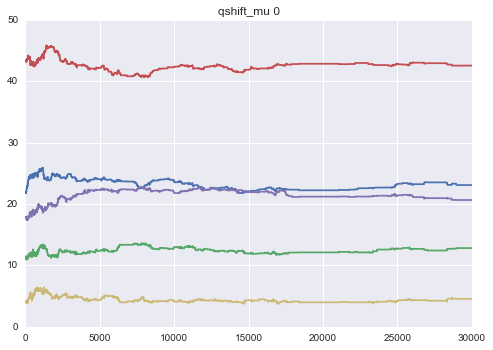

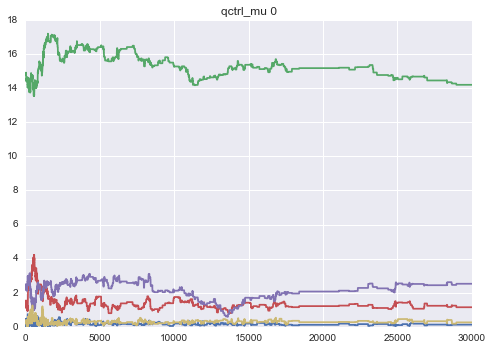

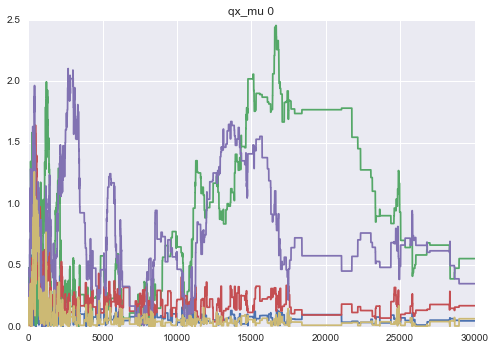

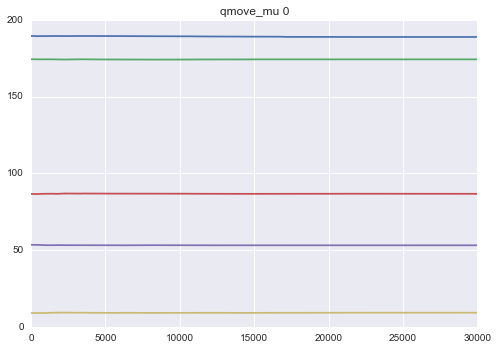

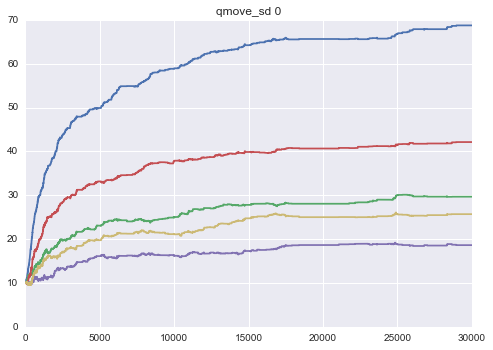

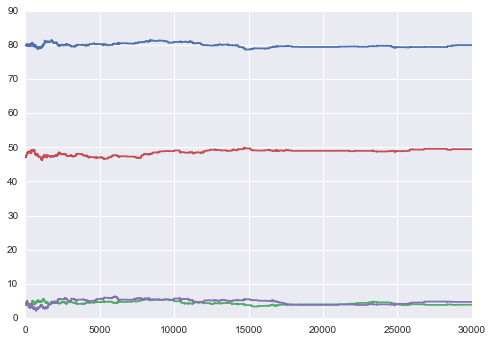

In [22]:
diagnose(channel=[0,1,2,3,4])

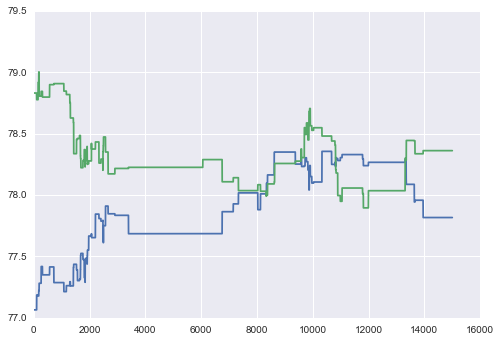

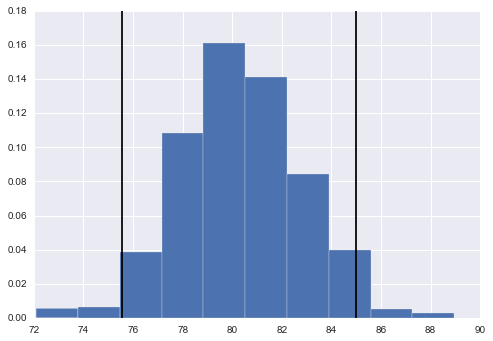

80.3509 2.45733 75.5516 84.974


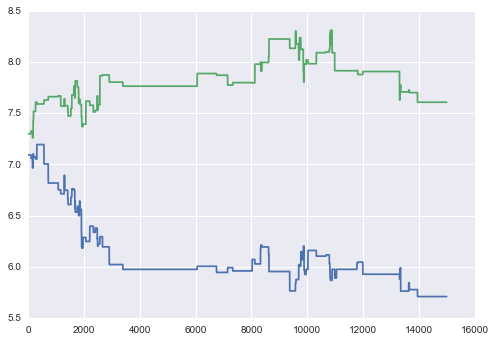

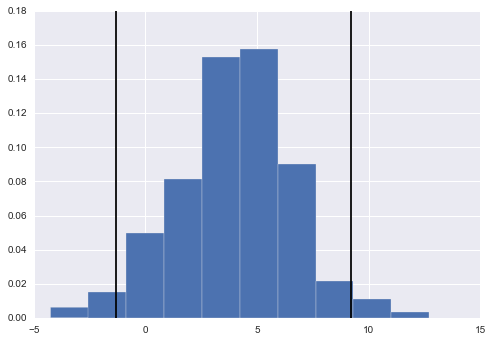

3.97903 2.59704 -1.29719 9.2233


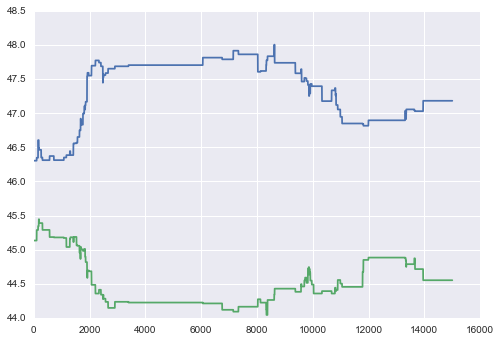

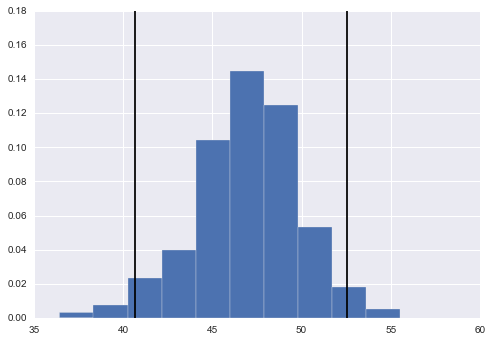

46.9125 2.91676 40.6564 52.5119


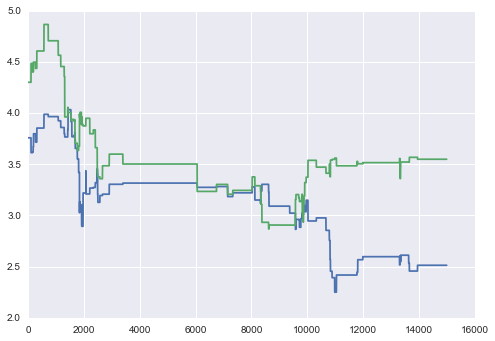

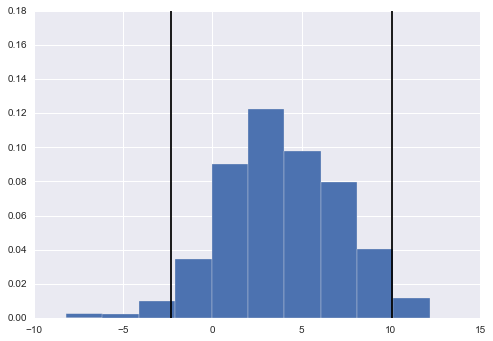

3.89529 3.24648 -2.29355 10.0687


In [23]:
for i in range(durations_num):
    plt.plot(qdurations.params.eval()[15000:,[1,2],i])
    plt.show()
    qd = qdurations.params.eval()[15000:,:,i].flatten()
    qd.sort()
    plt.hist(qd,normed=True)
    plt.vlines([qd[int(len(qd)*0.025)],qd[int(len(qd)*0.975)]],0.0,0.18)
    plt.show()
    print(qd.mean(),qd.std(),qd[int(len(qd)*0.025)],qd[int(len(qd)*0.975)])

In [34]:
res = qdurations.params.eval()[15000:,:,:]

In [35]:
res.shape

(15000, 202, 4)

In [37]:
res[0,0,:]

array([ 78.68280029,   3.7235136 ,  49.685112  ,   5.42783546], dtype=float32)

In [38]:
br = res.cumsum(axis=2)
br[0,0,:]

array([  78.68280029,   82.40631104,  132.09143066,  137.51927185], dtype=float32)

In [41]:
brs = br.reshape([br.shape[0]*br.shape[1],4])
brs[0]

array([  78.68280029,   82.40631104,  132.09143066,  137.51927185], dtype=float32)

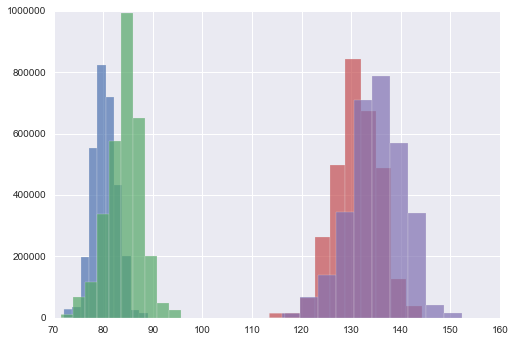

In [44]:
plt.hist(brs[:,0],alpha=0.7)
plt.hist(brs[:,1],alpha=0.7)
plt.hist(brs[:,2],alpha=0.7)
plt.hist(brs[:,3],alpha=0.7)
plt.show()

In [46]:
stage_list[0].shape

(202, 4, 193)

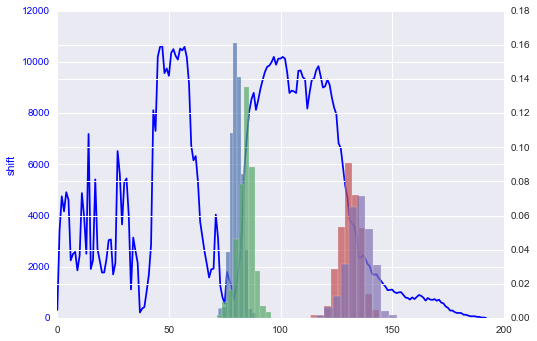

In [61]:
keys = ['shift','ctrl','x','move']
second = 60

key = 0

plt.plot(stage_list[0][:,key,:].sum(axis=0),label="{}".format(keys[key]),color='b')
plt.ylabel(keys[0],color='b')
plt.yticks(color='b')
plt.twinx()

plt.hist(brs[:,0],alpha=0.7,normed=True)
plt.hist(brs[:,1],alpha=0.7,normed=True)
plt.hist(brs[:,2],alpha=0.7,normed=True)
plt.hist(brs[:,3],alpha=0.7,normed=True)
'''
plt.plot(stage_list[0][:,2,:].sum(axis=0),label="{}".format(keys[0]),color='r')
plt.ylabel(keys[1],color='r')
plt.yticks(color='r')
plt.title('stage {} count ({} frame)'.format(i+1, second))
'''
#plt.vlines(cut_mat[i],0,600)


plt.show()


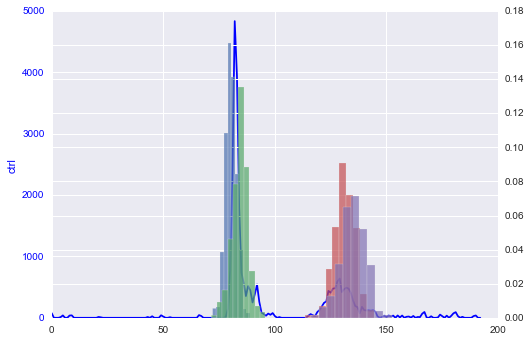

In [63]:
keys = ['shift','ctrl','x','move']
second = 60

key = 1

plt.plot(stage_list[0][:,key,:].sum(axis=0),label="{}".format(keys[key]),color='b')
plt.ylabel(keys[key],color='b')
plt.yticks(color='b')
plt.twinx()

plt.hist(brs[:,0],alpha=0.7,normed=True)
plt.hist(brs[:,1],alpha=0.7,normed=True)
plt.hist(brs[:,2],alpha=0.7,normed=True)
plt.hist(brs[:,3],alpha=0.7,normed=True)
'''
plt.plot(stage_list[0][:,2,:].sum(axis=0),label="{}".format(keys[0]),color='r')
plt.ylabel(keys[1],color='r')
plt.yticks(color='r')
plt.title('stage {} count ({} frame)'.format(i+1, second))
'''
#plt.vlines(cut_mat[i],0,600)


plt.show()


In [64]:
def bihist(key):
    keys = ['shift','ctrl','x','move']
    second = 60

    #key = 1

    plt.plot(stage_list[0][:,key,:].sum(axis=0),label="{}".format(keys[key]),color='b')
    plt.ylabel(keys[key],color='b')
    plt.yticks(color='b')
    plt.twinx()

    plt.hist(brs[:,0],alpha=0.7,normed=True)
    plt.hist(brs[:,1],alpha=0.7,normed=True)
    plt.hist(brs[:,2],alpha=0.7,normed=True)
    plt.hist(brs[:,3],alpha=0.7,normed=True)
    '''
    plt.plot(stage_list[0][:,2,:].sum(axis=0),label="{}".format(keys[0]),color='r')
    plt.ylabel(keys[1],color='r')
    plt.yticks(color='r')
    plt.title('stage {} count ({} frame)'.format(i+1, second))
    '''
    #plt.vlines(cut_mat[i],0,600)


    plt.show()


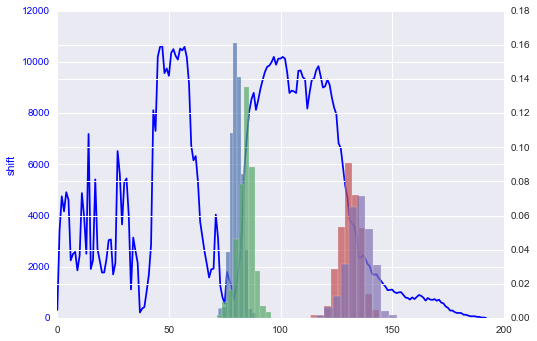

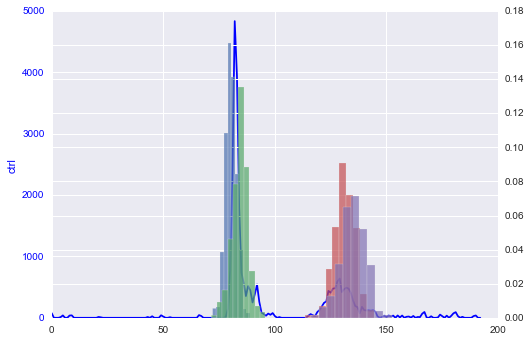

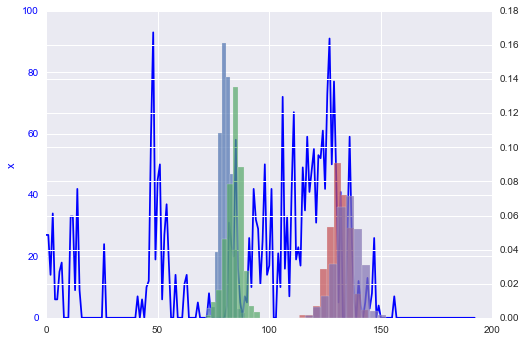

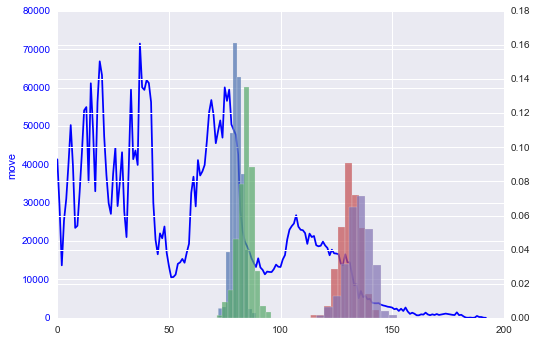

In [65]:
for  i in range(4):
    bihist(i)

下面是对一次实验结果的暂存

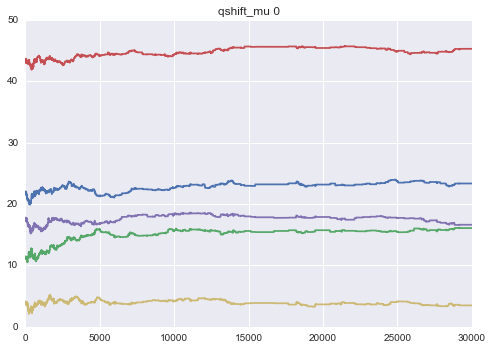

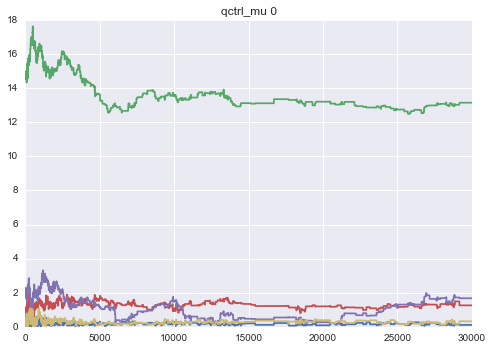

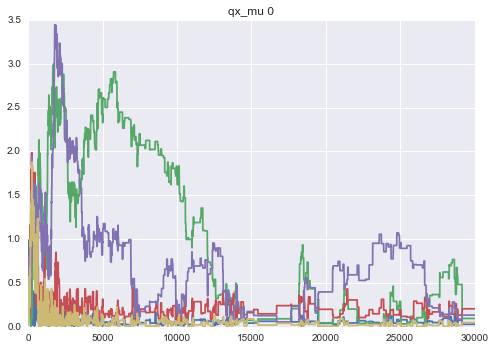

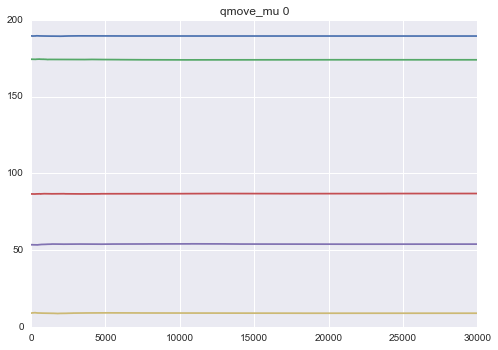

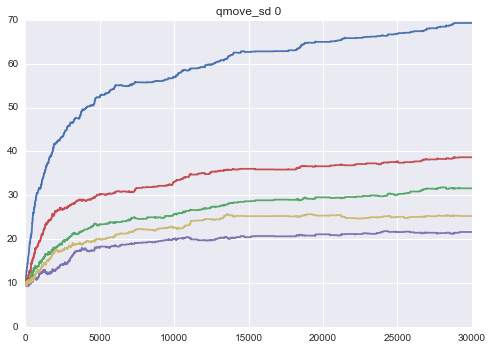

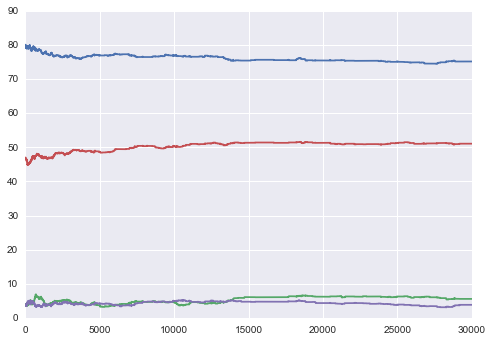

In [23]:
diagnose(channel=[0,1,2,3,4])

In [27]:
qdurations.params.shape

TensorShape([Dimension(30000), Dimension(202), Dimension(4)])

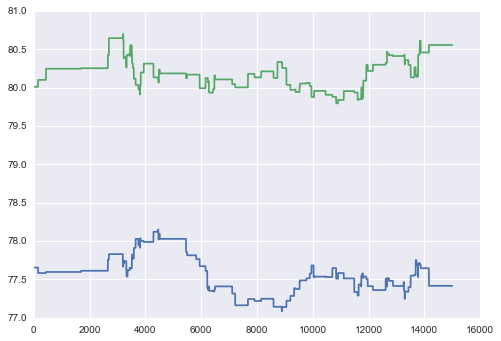

In [34]:
plt.plot(qdurations.params.eval()[15000,[1,2],0])

这是两个durations序列的duration 1 的采样轨道

In [46]:
qd = qdurations.params.eval()[15000:,:,0].flatten()
qd.sort()

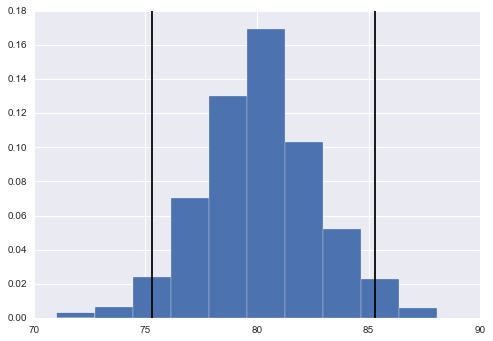

In [52]:
plt.hist(qd,normed=True)
plt.vlines([qd[int(len(qd)*0.025)],qd[int(len(qd)*0.975)]],0.0,0.18)
plt.show()

In [54]:
print(qd.mean(),qd.std(),qd[int(len(qd)*0.025)],qd[int(len(qd)*0.975)])

80.1628 2.58189 75.2905 85.2857


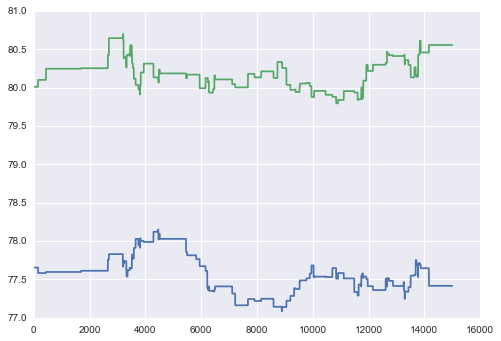

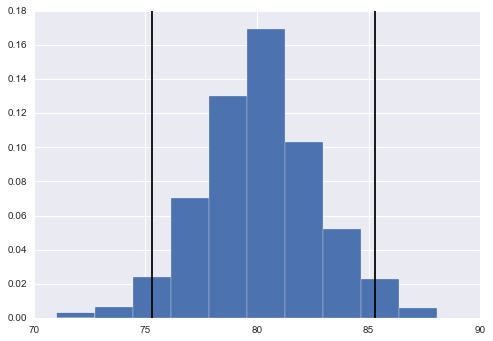

80.1628 2.58189 75.2905 85.2857


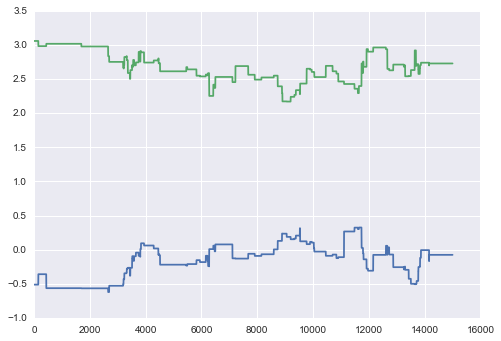

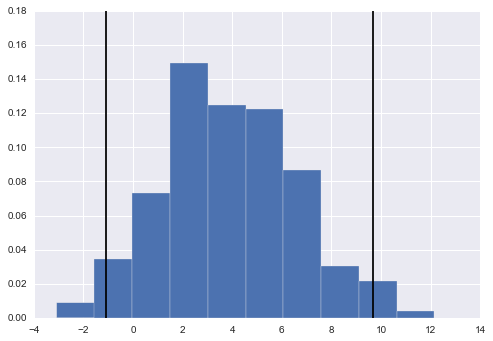

3.92518 2.68015 -1.10631 9.65699


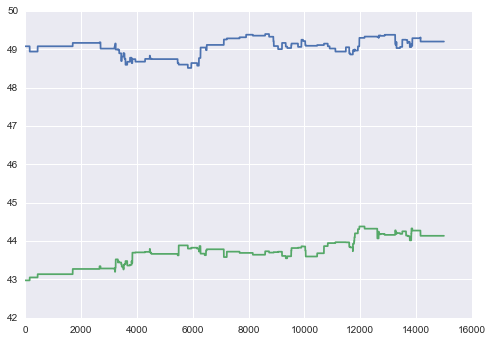

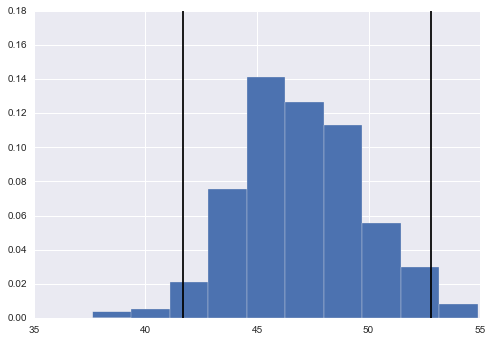

47.0071 2.78006 41.7014 52.8148


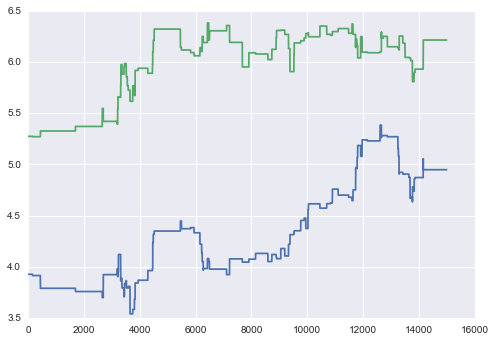

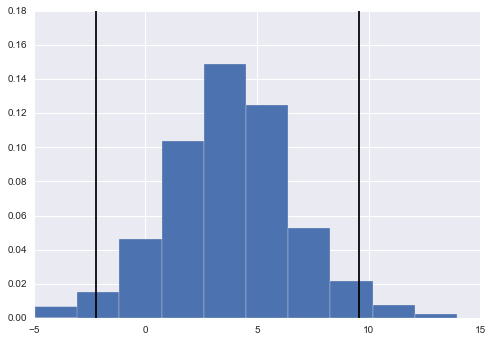

3.79284 2.82914 -2.21054 9.58606


In [55]:
for i in range(durations_num):
    plt.plot(qdurations.params.eval()[15000:,[1,2],i])
    plt.show()
    qd = qdurations.params.eval()[15000:,:,i].flatten()
    qd.sort()
    plt.hist(qd,normed=True)
    plt.vlines([qd[int(len(qd)*0.025)],qd[int(len(qd)*0.975)]],0.0,0.18)
    plt.show()
    print(qd.mean(),qd.std(),qd[int(len(qd)*0.025)],qd[int(len(qd)*0.975)])

In [35]:
np.random.randint(0,2,10)

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 0])

In [ ]:
plt.plot(qdurations.params.eval()[15000:,np.random,0])

上面把四变量模型改成了五阶段而不是三阶段，不过并没有退化为只考虑ctrl的模型。下面的则实现了

In [16]:
# MODEL

#durations = ed.models.Normal(loc = [80.0,51.0], scale=[3.0,10.0], sample_shape=replay_num) # 202 * 2 matrix
durations = ed.models.Normal(loc = time_length[:,0], scale=time_length[:,1], sample_shape=replay_num) # 202 * 4 matrix
breaks = tf.cumsum(durations, axis=1) # 202 * 4 matrix
#_breaks = tf.transpose(tf.reshape(tf.tile(breaks,(stage_length, 1)),(stage_length,replay_num,2)),(1,2,0))  
_breaks = tf.transpose(tf.reshape(tf.tile(breaks,(stage_length, 1)),(stage_length,replay_num,durations_num)),(1,2,0))  
_mask = tf.where(_time_axis > _breaks, 
                 tf.ones((replay_num, durations_num, stage_length),dtype=tf.int32), 
                 tf.zeros((replay_num, durations_num, stage_length),dtype=tf.int32))
index = tf.reduce_sum(_mask, axis=1)

# 几个参数就不一样了

'''
_shift_mu = np.array([stage[:,0,:80].mean(),stage[:,0,80:131].mean(),stage[:,0,131:].mean()],dtype='float32')
_ctrl_mu  = np.array([stage[:,1,:80].mean(),stage[:,1,80:131].mean(),stage[:,1,131:].mean()],dtype='float32')
_x_mu     = np.array([stage[:,2,:80].mean(),stage[:,2,80:131].mean(),stage[:,2,131:].mean()],dtype='float32')
_move_mu  = np.array([stage[:,3,:80].mean(),stage[:,3,80:131].mean(),stage[:,3,131:].mean()],dtype='float32')
_move_sd  = np.array([stage[:,3,:80].std(), stage[:,3,80:131].std(), stage[:,3,131:].std() ],dtype='float32')
'''
#_shift_mu = meansd[:,0,0]
_ctrl_mu  = meansd[:,1,0]
#_x_mu     = meansd[:,2,0]
#_move_mu  = meansd[:,3,0]
#_move_sd  = meansd[:,3,1]


#shift_mu = ed.models.Exponential(rate = 1/_shift_mu)
ctrl_mu = ed.models.Exponential(rate = 1/_ctrl_mu)
#x_mu = ed.models.Exponential(rate = 1/_x_mu)
#move_mu = ed.models.Exponential(rate = 1/_move_mu) # 虽然这里也可以不是指数分布。。但反正它肯定是正的。。
#move_sd = ed.models.Exponential(rate = 1/_move_sd) # 虽然这里也可以不是指数分布。。但反正它肯定是正的。。

def share_params_into_period(var, index):
    var_list = []
    for i in range(replay_num):
        var_list.append(tf.gather(var,index[i]))
    var_along_replay = tf.stack(var_list)
    return var_along_replay

#shift_mu_time = share_params_into_period(shift_mu, index)
ctrl_mu_time = share_params_into_period(ctrl_mu, index)
#x_mu_time = share_params_into_period(x_mu, index)
#move_mu_time = share_params_into_period(move_mu, index)
#move_sd_time = share_params_into_period(move_sd, index)

#pressing_shift = ed.models.Poisson(rate = shift_mu_time)
pressing_ctrl = ed.models.Poisson(rate = ctrl_mu_time)
#pressing_x = ed.models.Poisson(rate = x_mu_time)
#move = ed.models.Normal(loc = shift_mu_time, scale = move_sd_time)

pressing_ctrl

<ed.RandomVariable 'Poisson_2/' shape=(202, 193) dtype=float32>

In [22]:
# Inference
T = 30000

idurations = np.ones([T, replay_num, durations_num],dtype='float32')
idurations[0,:,:] = np.array(time_length[:,0], dtype='float32') 
idurations[0,:,:] = np.array(time_length[:,0], dtype='float32') + 5  # system noise
qdurations = ed.models.Empirical(tf.Variable(idurations))

# 神他妈一堆样板代码，不过没精力想怎么重构了
#ishift_mu = np.ones([T,period_num],dtype='float32')
#ishift_mu[0,:] = _shift_mu
#qshift_mu = ed.models.Empirical(tf.Variable(ishift_mu))

ictrl_mu = np.ones([T,period_num],dtype='float32')
ictrl_mu[0,:] = _ctrl_mu
#ictrl_mu[0,:] = _ctrl_mu + 1.0 # system noise
qctrl_mu = ed.models.Empirical(tf.Variable(ictrl_mu))

#ix_mu = np.ones([T,period_num],dtype='float32')
#ix_mu[0,:] = _x_mu
#qx_mu = ed.models.Empirical(tf.Variable(ix_mu))

#imove_mu = np.ones([T,period_num],dtype='float32')
#imove_mu[0,:] = _move_mu
#qmove_mu = ed.models.Empirical(tf.Variable(imove_mu))

#imove_sd = np.ones([T,period_num],dtype='float32')
#imove_sd[0,:] = _move_sd
#qmove_sd = ed.models.Empirical(tf.Variable(imove_sd))


# proposal variable

#gdurations = ed.models.Normal(loc = durations, scale = np.tile([0.01]*durations_num,[replay_num,1]).astype('float32'))
gdurations = ed.models.Normal(loc = durations, scale = np.tile([0.1]*durations_num,[replay_num,1]).astype('float32'))

poi_scale = 0.1 # 经实验发现那些泊松的参数接受率太低，故降低游走标准差
sd_scale = 0.1 # 经实验发现scale有趋势，且在30000次以内不能终结，于是加大其标准差增快搜索

#gshift_mu = ed.models.Normal(loc = shift_mu, scale = [poi_scale]*period_num)
gctrl_mu = ed.models.Normal(loc = ctrl_mu, scale = [poi_scale]*period_num)
#gx_mu = ed.models.Normal(loc = x_mu, scale = [poi_scale]*period_num)
#gmove_mu = ed.models.Normal(loc = move_mu, scale = [0.01]*period_num)
#gmove_sd = ed.models.Normal(loc = move_sd, scale = [sd_scale]*period_num)


In [23]:
inference = ed.MetropolisHastings({durations: qdurations, 
                                   ctrl_mu: qctrl_mu},
                      proposal_vars = {durations: gdurations, 
                                       ctrl_mu: gctrl_mu},
                      data = {pressing_ctrl: stage[:,1,:]})

In [24]:
inference.run()

30000/30000 [100%] ██████████████████████████████ Elapsed: 296s | Acceptance Rate: 0.006


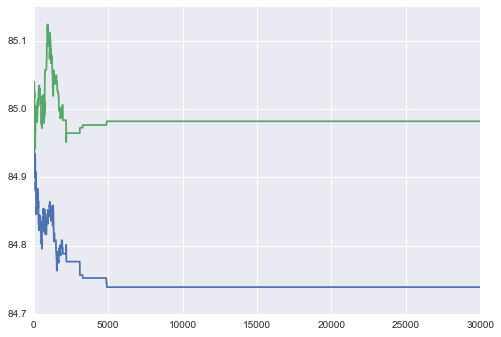

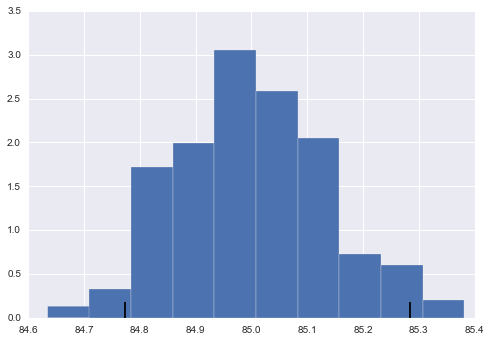

85.0016 0.13318 84.7732 85.2848


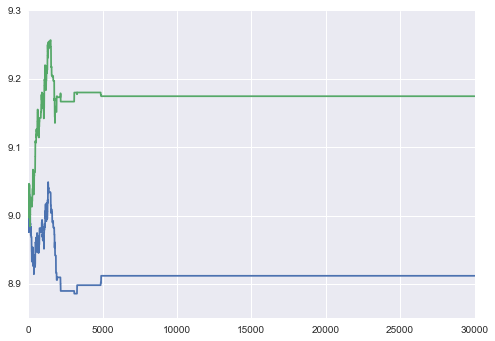

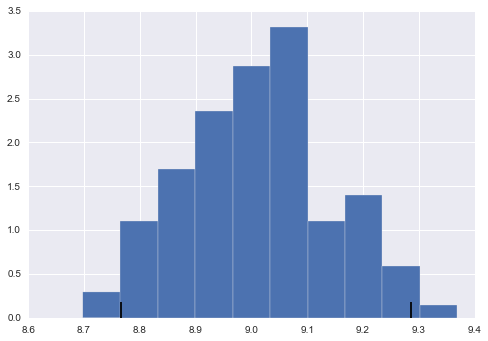

9.01029 0.130968 8.76705 9.28601


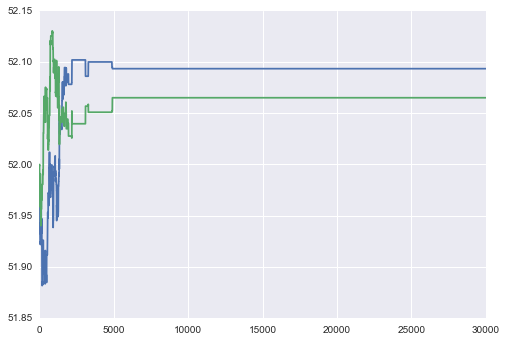

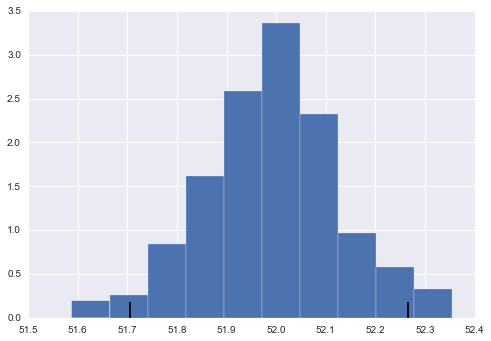

51.9935 0.136542 51.7059 52.2648


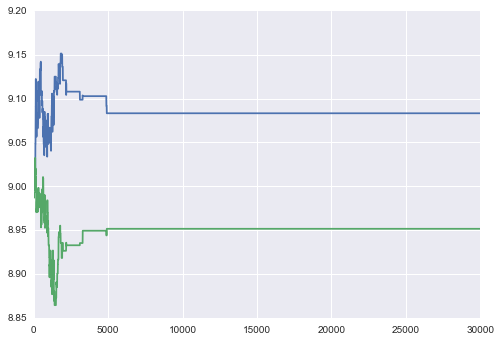

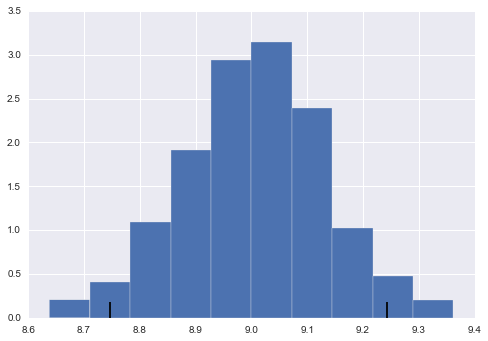

9.00375 0.127481 8.74667 9.24248


In [25]:
for i in range(durations_num):
    plt.plot(qdurations.params.eval()[:,[1,2],i])
    plt.show()
    qd = qdurations.params.eval()[15000:,:,i].flatten()
    qd.sort()
    plt.hist(qd,normed=True)
    plt.vlines([qd[int(len(qd)*0.025)],qd[int(len(qd)*0.975)]],0.0,0.18)
    plt.show()
    print(qd.mean(),qd.std(),qd[int(len(qd)*0.025)],qd[int(len(qd)*0.975)])

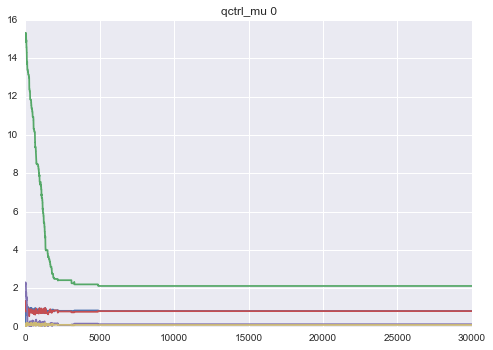

In [26]:
plt.plot(qctrl_mu.params.eval())
plt.title('qctrl_mu 0')
plt.show()
